In [1]:
from scipy.interpolate import griddata
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, BatchNormalization

tf.random.set_seed(42)
from sklearn.model_selection import train_test_split

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-29 15:11:49.173112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go

np.random.seed(42)

In [3]:
client = pd.read_csv("../../data/client.csv")
ePrices = pd.read_csv("../../data/electricity_prices.csv")
gasPrices = pd.read_csv("../../data/gas_prices.csv")
train = pd.read_csv("../../data/train.csv")

In [4]:
weatherPredInt = pd.read_csv("interpolPredWeather.csv")
weatherHistInt = pd.read_csv("../histWeatherSnowCover.csv")

# process data

### merge client & train, add business feat & interpolate daylight savings

In [5]:
producing = train.loc[train.is_consumption == 0]
consuming = train.loc[train.is_consumption == 1]
train = pd.merge(producing.drop('is_consumption',axis = 1), consuming.drop('is_consumption',axis = 1),on=['data_block_id','prediction_unit_id','datetime','county','is_business','product_type'], how='outer',suffixes=('_prod', '_cons'))
del producing, consuming
print(train.shape)

clientsTime = pd.merge(train, client, on=['county','is_business','product_type','data_block_id'], how='inner')

clientsTime['datetime'] = pd.to_datetime(clientsTime['datetime'])
clientsTime['yearday'] = clientsTime['datetime'].dt.day_of_year
clientsTime['weekday'] = clientsTime['datetime'].dt.day_of_week
clientsTime['month'] = clientsTime['datetime'].dt.month
clientsTime['monthday'] = clientsTime['datetime'].dt.day
clientsTime['year'] = clientsTime['datetime'].dt.year

unique_pairs = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs)}
clientsTime['business_prodType'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'])))

unique_pairs_cust = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs_cust)}
clientsTime['ind_customer_id'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))

# interpolate daylight savings
clientsTime = clientsTime.interpolate()

(1009176, 10)


/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_50914/1767582791.py:25: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



#### get holidays

In [6]:
import holidays
from datetime import date

us_holidays = holidays.EE()  # this is a dict

clientsTime['holiday'] = clientsTime['datetime'].apply(lambda s : s in us_holidays)

In [7]:
clientsTime['no_workday'] = ((clientsTime['holiday']) | (clientsTime['weekday'] > 4))

### prepare electric prices

<Axes: >

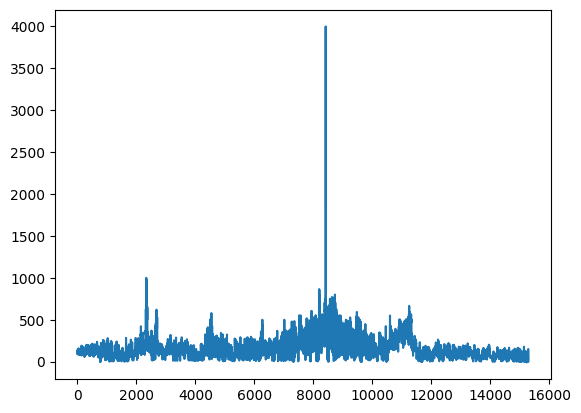

In [8]:
ePrices.euros_per_mwh.plot()

In [9]:
ePrices['forecast_date'] = pd.to_datetime(ePrices['forecast_date'])

# Set 'timestamp' as the index
ePrices.set_index('forecast_date', inplace=True)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_50914/2052008978.py:10: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



In [10]:
ePrices['euros_per_mwh'] = ePrices.euros_per_mwh.replace(4000.0, np.nan)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_50914/4094142437.py:7: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



# write data into python arrays

In [11]:
#clientsTime, weatherPredInt, weatherHistInt, ePrices, gasPrices

featPredWeather = [
        #'latitude', 'longitude', 
        'County', #'forecast_datetime',
       'hours_ahead',
        'data_block_id', #'origin_datetime', 
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       #'sunrise', 'sunset',
       #'daylight', 'minDaylight'
       ]

predWeatherComplete = weatherPredInt[featPredWeather]
del weatherPredInt

featHistWeather = [
       #'latitude', 'longitude', 
       'County',
       #'datetime', 
       'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover'
]
histWeatherComplete = weatherHistInt[featHistWeather]
del weatherHistInt

# can't use client id as an axis in data because it's not constant!
y = np.zeros((clientsTime.shape[0],2))
y_indexes = np.zeros((clientsTime.shape[0],2)) # dataframe indexes in the end, not important for now
index_y = 0

customers = []

constValsArray = np.zeros((1,17))
targetsArray = np.zeros((1,24,2))
ePricesArray = np.zeros((1,24,1))

nFeatHistWeather = histWeatherComplete.shape[1]-1
histWeatherArray = np.zeros((1,24,nFeatHistWeather))
nFeatPredWeather = predWeatherComplete.shape[1]-1
predWeatherArray = np.zeros((1,24,nFeatPredWeather))
dataBlockIdArray = np.zeros((1))

# loop over customer, append all data cycles for each customer
for customerId in clientsTime.ind_customer_id.unique():
    customerSlice = clientsTime.loc[clientsTime.ind_customer_id == customerId]

    for dataBlockId in customerSlice.data_block_id.unique():
        timeSlice = customerSlice.loc[customerSlice.data_block_id == dataBlockId]
        gasSlice = gasPrices.loc[gasPrices.data_block_id == dataBlockId]
        eSlice   = ePrices.loc[ePrices.data_block_id == dataBlockId]

        if len(timeSlice.yearday.unique()) > 1:
            print(timeSlice.yearday.unique())

        # const values
        yearday = timeSlice.yearday.unique()[0]
        weekday = timeSlice.weekday.unique()[0]
        month   = timeSlice.month.unique()[0]
        monthday = timeSlice.monthday.unique()[0]
        year = timeSlice.year.unique()[0]

        holiday = timeSlice.holiday.unique()[0]
        noWorkDay = timeSlice.no_workday.unique()[0]

        county       = customerSlice.county.unique()[0]
        is_business  = customerSlice.is_business.unique()[0]
        product_type = customerSlice.product_type.unique()[0]
        prediction_unit_id = customerSlice.prediction_unit_id.unique()[0] #should be redundant
        eic_count          = customerSlice.eic_count.unique()[0]
        installed_capacity = customerSlice.installed_capacity.unique()[0]
    
        business_prodType = customerSlice.business_prodType.unique()[0]
        ind_customer_id   = customerSlice.ind_customer_id.unique()[0]

        

        lowest_price_per_mwh = gasSlice.lowest_price_per_mwh.iloc[0]
        highest_price_per_mwh = gasSlice.highest_price_per_mwh.iloc[0]
        euros_per_mwh = eSlice['euros_per_mwh'].to_numpy()
        if euros_per_mwh.shape[0] == 23:
            print(dataBlockId, customerId)

        y_cons = timeSlice['target_cons'] / installed_capacity
        y_prod = timeSlice['target_prod'] / installed_capacity

        histWeather = histWeatherComplete.loc[(histWeatherComplete.data_block_id == dataBlockId) & (histWeatherComplete.County == county)]
        predWeather = predWeatherComplete.loc[(predWeatherComplete.data_block_id == dataBlockId) & (predWeatherComplete.County == county)]

        histWeather = histWeather.drop('data_block_id', axis = 1)
        predWeather = predWeather.drop('data_block_id', axis = 1)


        if y_cons.shape[0] == 23:
            print(dataBlockId, customerId)

        new_row = np.array([county, is_business, product_type, prediction_unit_id, eic_count, installed_capacity, 
        business_prodType,ind_customer_id,lowest_price_per_mwh,highest_price_per_mwh,
        yearday,weekday,month,monthday,year,holiday,noWorkDay
        ])
        constValsArray = np.vstack((constValsArray, new_row))

        new_row = np.zeros((1,24,2))
        new_row[:,:,0] = y_cons
        new_row[:,:,1] = y_prod
        targetsArray = np.concatenate((targetsArray, new_row), axis=0)

        new_row = np.zeros((1,24,1))
        new_row[0,:,0] = euros_per_mwh
        ePricesArray = np.concatenate((ePricesArray, new_row), axis=0)

        new_row = np.zeros((1,24,nFeatHistWeather)) #without datablock id
        new_row[:,:,:] = histWeather
        histWeatherArray = np.concatenate((histWeatherArray, new_row), axis=0)

        new_row = np.zeros((1,24,nFeatPredWeather)) # withotu datablock id
        new_row[:,:,:] = predWeather
        predWeatherArray = np.concatenate((predWeatherArray, new_row), axis=0)

        dataBlockIdArray = np.concatenate((dataBlockIdArray, np.array([dataBlockId])))
    


In [12]:
#remove first rows
targetsArray     = targetsArray[1:,:,:]
constValsArray   = constValsArray[1:,:]
ePricesArray     = ePricesArray[1:,:,:]
histWeatherArray = histWeatherArray[1:,:,:]
predWeatherArray = predWeatherArray[1:,:,:]
dataBlockIdArray = dataBlockIdArray[1:]
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

(41869, 24, 2) (41869, 17) (41869, 24, 1) (41869, 24, 18) (41869, 24, 14) (41869,)


In [13]:
#calc absolute targets, not normalized by capacity
targetsAbs = targetsArray.copy()
targetsAbs = targetsAbs * constValsArray[:,5].reshape(constValsArray.shape[0],1,1)
print(targetsAbs.shape)

(41869, 24, 2)


In [14]:
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

(41869, 24, 2) (41869, 17) (41869, 24, 1) (41869, 24, 18) (41869, 24, 14) (41869,)


In [15]:
np.savez('data_arrays_snowcover_holidays.npz', arr1=targetsArray, arr2=constValsArray, arr3=ePricesArray, arr4 = histWeatherArray, arr5=predWeatherArray, arr6=dataBlockIdArray, arr7=targetsAbs)

# load data & preselect data

In [58]:
loaded_data = np.load('data_arrays_snowcover_holidays.npz')

# Access individual arrays by their keys
targetsArray = loaded_data['arr1']
constValsArray = loaded_data['arr2']
ePricesArray = loaded_data['arr3']
histWeatherArray = loaded_data['arr4']
predWeatherArray = loaded_data['arr5']
dataBlockIdArray = loaded_data['arr6']
targetsAbs = loaded_data['arr7']


featPredWeather = [
        'County',
       'hours_ahead',
       # 'data_block_id',
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 
       'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       ]
featPredWeatherKeepIdx = [0,1,2,3,4,5,6,10,11,12,13]
predWeatherArray=predWeatherArray[:,:,featPredWeatherKeepIdx]
featPredWeather = [featPredWeather[i] for i in featPredWeatherKeepIdx]

#correct hours
predWeatherArray[:,:,1] = predWeatherArray[:,:,1] - 24

# add sin of hours
sinDay = np.reshape(np.sin((predWeatherArray[:,:,1] - 24)*np.pi/24),(predWeatherArray.shape[0],predWeatherArray.shape[1],1))
predWeatherArray = np.concatenate((predWeatherArray, sinDay), axis=2)
featPredWeatherKeepIdx = featPredWeatherKeepIdx + [len(featPredWeatherKeepIdx)] 
featPredWeather = featPredWeather + ['sinDay']

cosDay = np.reshape(np.cos((predWeatherArray[:,:,1] - 24)*np.pi/24),(predWeatherArray.shape[0],predWeatherArray.shape[1],1))
predWeatherArray = np.concatenate((predWeatherArray, cosDay), axis=2)
featPredWeatherKeepIdx = featPredWeatherKeepIdx + [len(featPredWeatherKeepIdx)] 
featPredWeather = featPredWeather + ['cosDay']
nPredFeat = predWeatherArray.shape[2]

featPredWeatherKeepIdx = [2,3,13,14,15]



featConst =['county', 'is_business', 'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity', 'business_prodType', 'ind_customer_id',
'lowest_price_per_mwh','highest_price_per_mwh','yearday','weekday','month','monthday','year','holiday','no_workday'
]

featConstKeepIdx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

# add sin of year day
yeardayIdx = featConstKeepIdx.index(10)
CapIdx = featConstKeepIdx.index(5)
sinYear = np.reshape(np.sin(2*constValsArray[:,yeardayIdx]*np.pi/365),(constValsArray.shape[0],1))
constValsArray = np.concatenate((constValsArray, sinYear), axis=1)
featConst = featConst + ['sinYearDay']

cosYear = np.reshape(np.cos(2*constValsArray[:,yeardayIdx]*np.pi/365),(constValsArray.shape[0],1))
constValsArray = np.concatenate((constValsArray, cosYear), axis=1)
featConst = featConst + ['cosYearDay']




featConstKeepIdx = [0,1,2,5,6,8,9,13,16,17,18]
constValsArray=constValsArray[:,featConstKeepIdx]
featConst = [featConst[i] for i in featConstKeepIdx]
nConst = constValsArray.shape[1]



featHistWeather = [
       'County', 
       #'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover'
]
featHistWeatherKeepIdx = [1,10]
histWeatherArray=histWeatherArray[:,:,featHistWeatherKeepIdx]

featHistWeather = [featHistWeather[i] for i in featHistWeatherKeepIdx]
nHistFeat = histWeatherArray.shape[2]


targetsAbs[:,0] = targetsAbs[:,0]#-800

print(nPredFeat,nHistFeat,nConst)

5 2 11


# build a model & train it

#### split data based on time

In [18]:
trainSplit = int(max(dataBlockIdArray)*0.5)
mask = dataBlockIdArray < trainSplit

In [130]:
shuffledArr = [constValsArray,ePricesArray,histWeatherArray,predWeatherArray,targetsAbs,targetsArray,dataBlockIdArray]


X_train = [shuffledArr[0][mask],shuffledArr[1][mask],shuffledArr[2][mask],shuffledArr[3][mask]]
# only const and e prices
X_train = [shuffledArr[0][mask]]#,shuffledArr[1][mask]]#,shuffledArr[3][mask]]
y_trainAbs = shuffledArr[4][mask]
y_train = shuffledArr[5][mask]

X_test = [shuffledArr[0][~mask]]#,shuffledArr[1][~mask],shuffledArr[3][~mask]]
y_testAbs = shuffledArr[4][~mask]
y_test = shuffledArr[5][~mask]

#### shuffle if needed & split into x train y train

In [5]:

index_array = np.arange(targetsArray.shape[0])
if 0: #not shuffle!!
    np.random.shuffle(index_array)

arrays = [constValsArray,ePricesArray,histWeatherArray,predWeatherArray,targetsAbs,targetsArray,dataBlockIdArray]
shuffledArr = [arr[index_array] for arr in arrays]
del arrays

In [6]:
trainSplit = int(shuffledArr[4].shape[0]*0.8)
X_train = [shuffledArr[0][0:trainSplit,:],shuffledArr[1][0:trainSplit,:,:],shuffledArr[2][0:trainSplit,:,:],shuffledArr[3][0:trainSplit,:,:]]
# only const and e prices
X_train = [shuffledArr[0][0:trainSplit,:]]#,shuffledArr[1][0:trainSplit,:,:]]
y_trainAbs = shuffledArr[4][0:trainSplit,:]
y_train = shuffledArr[5][0:trainSplit,:]

X_test = [shuffledArr[0][trainSplit:-1,:]]#,shuffledArr[1][trainSplit:-1,:,:]]
y_testAbs = shuffledArr[4][trainSplit:-1,:]
y_test = shuffledArr[5][trainSplit:-1,:]

#### calculate class weights

In [24]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(X_train[0][:,yeardayIdx]), y=X_train[0][:,yeardayIdx])

class_weight_dict = dict(enumerate(class_weights))

#### use standard scaler for train data

In [103]:
# normalize the target
from sklearn.preprocessing import StandardScaler

scaler0 = StandardScaler()
X_train[0] = scaler0.fit_transform(X_train[0])
X_test[0]  = scaler0.transform(X_test[0])

#scaler1 = StandardScaler()
#X_train[1] = scaler1.fit_transform(X_train[1].reshape(-1,1)).reshape(-1,24,1)
#X_test[1]  = scaler1.transform(X_test[1].reshape(-1,1)).reshape(-1,24,1)

#scaler2 = StandardScaler()
#X_train[2] = scaler2.fit_transform(X_train[2])
#X_test[2]  = scaler2.transform(X_test[2])

#### use standard scaler for target

In [ ]:
# normalize the target
from sklearn.preprocessing import StandardScaler

scalerT = StandardScaler()
y_trainAbsN_cons = scalerT.fit_transform(y_trainAbs[:,:,0].reshape(-1, 1)).reshape(-1,24,1)
y_testAbsN_cons  = scalerT.transform(y_testAbs[:,:,0].reshape(-1, 1)).reshape(-1,24,1)

#### use a label encoder for the eic count

In [ ]:
from sklearn.preprocessing import LabelEncoder

eicCountIdx = featConstKeepIdx.index(4)
# Assuming cat_feature is a categorical feature
encoder = LabelEncoder()
constValsArray[:,eicCountIdx] = encoder.fit_transform(constValsArray[:,eicCountIdx])

### define model & train it

### use a model for production and consumption separately

In [ ]:
# production
# Define the inputs
weatherPred_inputs1 = tf.keras.Input(shape=(24, 10), name='weatherPred_inputs1')
ePrices_inputs1 = tf.keras.Input(shape=(24, 1), name='ePrices_inputs1')

weatherHist_input1 = tf.keras.Input(shape=(24, 5), name='weatherHist_input1')
constant_inputs1 = tf.keras.Input(shape=(14,), name='constant_inputs1')

# Process the time-based inputs
weatherPred_flattened1 = layers.Flatten()(weatherPred_inputs1)
for i in range(0,3):
    weatherPred_flattened1 = layers.Dense(240, activation='relu')(weatherPred_flattened1)

weatherHist_flattened1 = layers.Flatten()(weatherHist_input1)
for i in range(0,3):
    weatherHist_flattened1 = layers.Dense(120, activation='relu')(weatherHist_flattened1)

ePrices_layer1 = layers.Flatten()(ePrices_inputs1)
ePrices_layer1 = layers.Dense(24, activation='relu')(ePrices_layer1)

# Concatenate all inputs
x1 = layers.Concatenate()([weatherPred_flattened1, weatherHist_flattened1, ePrices_layer1, constant_inputs1])

# Main dense block
for i in range(0,5):
    x1 = layers.Dense(540, activation='relu')(x1)
    #x = layers.Dropout(0.1)(x)

# Output layer for 24*2 targets
output_layer1 = layers.Dense(24 * 1, activation='linear', name='output1')(x1)
output_layer1 = layers.Reshape((24, 1))(output_layer1)

model2 = models.Model(inputs=[constant_inputs1,ePrices_inputs1, weatherHist_input1, weatherPred_inputs1], outputs=output_layer1)

# Compile the model with an appropriate loss function and optimizer
model2.compile(optimizer='adam', loss='mae')#, metrics=['mae'])
# 0 = cons, 1 = prod
history2 = model2.fit(X_train, y_trainAbs[:,:,1], validation_data=(X_test, y_testAbs[:,:,1]), epochs=100, batch_size=400) #batch size = 110 weather station

In [144]:
#consumption

#weatherPred_inputs2 = tf.keras.Input(shape=(24, nPredFeat), name='weatherPred_inputs2')
#ePrices_inputs2 = tf.keras.Input(shape=(24, 1), name='ePrices_inputs2')
#weatherHist_input2 = tf.keras.Input(shape=(24, 2), name='weatherHist_input2')
constant_inputs2 = tf.keras.Input(shape=(nConst,), name='constant_inputs2')

#weatherPred_inputs2_normalized = BatchNormalization()(weatherPred_inputs2)
#ePrices_inputs2_normalized = BatchNormalization()(ePrices_inputs2)
#weatherHist_input2_normalized = BatchNormalization()(weatherHist_input2)
constant_inputs2_normalized = BatchNormalization()(constant_inputs2)


#weatherPred_flattened2 = layers.Flatten()(weatherPred_inputs2_normalized)
#for i in range(0,1):
#    weatherPred_flattened2 = layers.Dense(24*nPredFeat, activation='relu')(weatherPred_flattened2)

#weatherHist_flattened2 = layers.Flatten()(weatherHist_input2_normalized)
#for i in range(0,3):
#    weatherHist_flattened2 = layers.Dense(48, activation='relu')(weatherHist_flattened2)

#ePrices_layer2 = layers.Flatten()(ePrices_inputs2_normalized)
#for i in range(0,1):
#    ePrices_layer2 = layers.Dense(24, activation='relu')(ePrices_layer2)
#
constInp_layer2 = layers.Dense(nConst, activation='relu')(constant_inputs2_normalized)
for i in range(0,0):
    constInp_layer2 = layers.Dense(16, activation='relu')(constInp_layer2)
#constInp_layer2 = layers.Dense(1, activation='relu')(constInp_layer2)

# Concatenate all inputs
#x2 = layers.Concatenate()([weatherPred_flattened2, ePrices_layer2,constInp_layer2])
#x2 = layers.Dense(160, activation='relu')(x2)
#x2 = layers.Dense(64, activation='relu')(x2)
#x2 = layers.Dense(24, activation='relu')(x2)

x2 = layers.Concatenate()([constInp_layer2]) #ePrices_layer2
#x2 = layers.Multiply()([ePrices_layer2, constInp_layer2])

# Main dense block
for i in range(0,1):
    x2 = layers.Dense(nConst, activation='relu')(x2) #making it bigger helps a bit, but not super significant
    #x = layers.Dropout(0.1)(x)

#x2 = layers.Dense(256, activation='relu')(x2)
#x2 = layers.Dense(128, activation='relu')(x2)
#x2 = layers.Dense(64, activation='relu')(x2)

# Output layer for 24*2 targets
output_layer2 = layers.Dense(24 * 1, activation='relu', name='output')(x2)
#output_layer2 = layers.Reshape((24, 1))(output_layer2)

#model3 = tf.keras.Model(inputs=[constant_inputs2,ePrices_inputs2, weatherHist_input2, weatherPred_inputs2], outputs=output_layer2)
model3 = tf.keras.Model(inputs=[constant_inputs2], outputs=output_layer2)


def absolute_loss(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))

# Compile the model with an appropriate loss function and optimizer
model3.compile(optimizer='adam', loss='mae')#absolute_loss, metrics=['mae'])
# 0 = cons, 1 = prod
#history3 = model3.fit(X_train, y_trainAbsN_cons, validation_data=(X_test, y_testAbsN_cons), epochs=100, batch_size=250)
history3 = model3.fit(X_train, y_trainAbs[:,:,0], validation_data=(X_test, y_testAbs[:,:,0]), epochs=300, batch_size=25000, class_weight=class_weight_dict)

Epoch 1/300
1/1 [==============================] - 0s 440ms/step - loss: 396.4303 - val_loss: 498.7962
Epoch 2/300
1/1 [==============================] - 0s 35ms/step - loss: 396.4272 - val_loss: 499.0743
Epoch 3/300
1/1 [==============================] - 0s 33ms/step - loss: 396.4240 - val_loss: 499.2121
Epoch 4/300
1/1 [==============================] - 0s 35ms/step - loss: 396.4208 - val_loss: 499.2979
Epoch 5/300
1/1 [==============================] - 0s 37ms/step - loss: 396.4175 - val_loss: 499.3575
Epoch 6/300
1/1 [==============================] - 0s 38ms/step - loss: 396.4142 - val_loss: 499.4013
Epoch 7/300
1/1 [==============================] - 0s 34ms/step - loss: 396.4107 - val_loss: 499.4349
Epoch 8/300
1/1 [==============================] - 0s 32ms/step - loss: 396.4073 - val_loss: 499.4614
Epoch 9/300
1/1 [==============================] - 0s 31ms/step - loss: 396.4037 - val_loss: 499.4826
Epoch 10/300
1/1 [==============================] - 0s 32ms/step - loss: 396.4002

In [147]:
#model3.optimizer.lr.assign(0.001)  # Set a new learning rate for subsequent calls to fit
history3 = model3.fit(X_train, y_trainAbs[:,:,0], validation_data=(X_test, y_testAbs[:,:,0]), epochs=1000, batch_size=40000)

Epoch 1/1000
1/1 [==============================] - 0s 75ms/step - loss: 152.1446 - val_loss: 219.4401
Epoch 2/1000
1/1 [==============================] - 0s 35ms/step - loss: 152.1374 - val_loss: 219.4432
Epoch 3/1000
1/1 [==============================] - 0s 32ms/step - loss: 152.1302 - val_loss: 219.4465
Epoch 4/1000
1/1 [==============================] - 0s 33ms/step - loss: 152.1230 - val_loss: 219.4495
Epoch 5/1000
1/1 [==============================] - 0s 32ms/step - loss: 152.1158 - val_loss: 219.4519
Epoch 6/1000
1/1 [==============================] - 0s 31ms/step - loss: 152.1086 - val_loss: 219.4536
Epoch 7/1000
1/1 [==============================] - 0s 32ms/step - loss: 152.1015 - val_loss: 219.4548
Epoch 8/1000
1/1 [==============================] - 0s 31ms/step - loss: 152.0943 - val_loss: 219.4559
Epoch 9/1000
1/1 [==============================] - 0s 31ms/step - loss: 152.0871 - val_loss: 219.4571
Epoch 10/1000
1/1 [==============================] - 0s 33ms/step - loss:

In [148]:
fig = go.Figure()
length = len(history3.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

In [112]:
a = model3.predict(X_test)
predVals = a*X_test[0][:,CapIdx].reshape(X_test[0].shape[0],1)
print(np.mean(np.abs(y_testAbs[:,:,0] - predVals)))
a = model3.predict(X_train)
predVals = a*X_train[0][:,CapIdx].reshape(X_train[0].shape[0],1)
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs[:,:,0]  - predVals)))
del a,predVals,trueVals

#only const feat
# 124/212 
# 91/181 -> no yearday
# 66/180 -> no yearday, holiday feat
# no normalization but scaler 60/200 -> bad
# same architecture, layer normalization  187/112 optimum,way better

# way better results with mae, rather than absolute loss
# 104/175 -> no yearday, weekday, monthday, holiday feat

# with e prices
# 98/178 (before overfitting)
# 72/177 (before overfitting) smaller network
# 91/175 (before overfitting) smaller network + relu activation function in last layer
# 82/173 (smaller network, relu)

# multiplicative
# 110/180
# concat
# 110/175

# with pred temp
# 95/186

# 34/67

# mean cons error single traines =35-37 (train) 53-57 (test) -> 34/63 -> 32/55
# mean prod error single trainer = 9-20 -> 10/18

668/668 [==============================] - 1s 693us/step
250.6049327457443
642/642 [==============================] - 1s 823us/step
92.67936684990086


In [ ]:
# reverse target scaling
a = model3.predict(X_test)
predVals = scalerT.inverse_transform(a.reshape(-1,1))
print(np.mean(np.abs(y_testAbs[:,:,0] - predVals.reshape(-1,24))))
a = model3.predict(X_train)
predVals = scalerT.inverse_transform(a.reshape(-1,1))
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs[:,:,0]  - predVals.reshape(-1,24))))
del a,predVals,trueVals

In [ ]:
model2.save('prod_model_GasPr_noSunrise_timeFeat.h5')
model3.save('cons_model_GasPr_noSunrise_timeFeat.h5')

# reconstruct dataframe and analyse results

In [20]:
# restructure dataframes, SHOULD BE CONST IF WE DON'T CHANGE MASK & NOT SHUFFLE
appendedList = []
shuffledDataBlockId = shuffledArr[6]
for i,data_block_id in enumerate(shuffledDataBlockId):
    isTrain = mask[i]
    
    new_columns = np.zeros((24, 2))  # Adjust the size according to your requirements

    #use targets as first block
    dataBlock = shuffledArr[4][i,:,:].reshape(24,2)

    #add train/test info & data block id
    new_columns = np.ones((24, 2)) * [isTrain, data_block_id]
    dataBlock = np.hstack((dataBlock, new_columns))
    #add const values
    new_columns = np.ones((24, nConst)) * shuffledArr[0][i,:].reshape(1,nConst)
    dataBlock = np.hstack((dataBlock, new_columns))
    #eprices (of yesterday)
    dataBlock = np.hstack((dataBlock, shuffledArr[1][i,:,:].reshape(24,1)))
    # add weather prediction
    dataBlock = np.hstack((dataBlock, shuffledArr[3][i,:,:].reshape(24,len(featPredWeatherKeepIdx))))
    # hist weather
    dataBlock = np.hstack((dataBlock, shuffledArr[2][i,:,:].reshape(24,len(featHistWeatherKeepIdx))))

    #hist weather, flatten the array and add all values as columns
    #new_columns = np.ones((24, 100)) * shuffledArr[2][i,:].reshape(1,100)
    #dataBlock = np.hstack((dataBlock, new_columns))

    appendedList.append(dataBlock)




feat = ['y_cons','y_prod','isTrain','data_block_id'] + featConst + ['ePrices'] + featPredWeather + featHistWeather
#for i in range(0,10):
#    feat = feat + [f'{value}_'+str(i) for value in featHistWeather]

appendedDf = pd.DataFrame(np.vstack(appendedList), columns=feat)

from datetime import datetime, timedelta
appendedDf['unique_time'] = appendedDf.apply(lambda row: datetime(row['year'].astype(int), 1, 1) + timedelta(days=row['yearday'] - 1, hours=row['hours_ahead']-24), axis=1)
#appendedDf['unique_time'] = appendedDf.apply(lambda row: datetime(2022, 1, 1) + timedelta(days=row['yearday'] - 1, hours=row['hours_ahead']-24), axis=1)
    
            

In [122]:
X2 = [shuffledArr[0],shuffledArr[1],shuffledArr[2],shuffledArr[3]]
X2 = [shuffledArr[0]]#,shuffledArr[1],shuffledArr[3]]
X2[0]  = scaler0.transform(X2[0])
pred_cons = model3.predict(X2)

#pred_cons = pred_cons*X2[0][:,CapIdx].reshape(X2[0].shape[0],1)
#pred_cons = scalerT.inverse_transform(pred_cons.reshape(-1,1)).reshape(-1,24,1)

appendedListProd = []
for i in range(0,pred_cons.shape[0]):
    appendedListProd.append(pred_cons[i,:].reshape(24,1))
    
appendedDf['pred_cons'] = np.vstack(appendedListProd)

appendedDf['absErr_cons'] = (appendedDf['y_cons']-appendedDf['pred_cons'])
print(X2[0].shape)



1309/1309 [==============================] - 1s 520us/step
(41869, 11)


# analyze dataframe
good generalization, test and train are pretty much always the same

production:
- overweighting big producers -> lots of errors for smaller capacities

consumption:
- bigger error in summer


In [123]:
trainDf = appendedDf.loc[appendedDf.isTrain == True]
testDf = appendedDf.loc[appendedDf.isTrain == False]

### investigate consumption
- some heavy overestimation (when no consumption but we predict one)
- some heave underestimation, when lots of consumption but no prediciton

we can't fit yearly trend!!
things that don't help:
- relu activation function doesn't help (but makes targets all positive)
- input normalization
- target normalization
- bigger network
- using less features to predict
- using weights on day doesn't help (but is definitely needed)


it seems that the consumption data is very sparse & hence really hard to fit 
-> try to find a normalization criteria


In [124]:
#train
print(trainDf.y_cons.mean(),trainDf.y_cons.std())
print(trainDf.pred_cons.mean(),trainDf.pred_cons.std())

421.2910771297334 1115.917790617789
411.64072 1107.39453125


In [125]:
#test
print(testDf.y_cons.mean(),testDf.y_cons.std())
print(testDf.pred_cons.mean(),testDf.pred_cons.std())

500.1512212070649 1275.1868397371024
632.56555 1733.6748046875


#### train

<Axes: xlabel='weekday'>

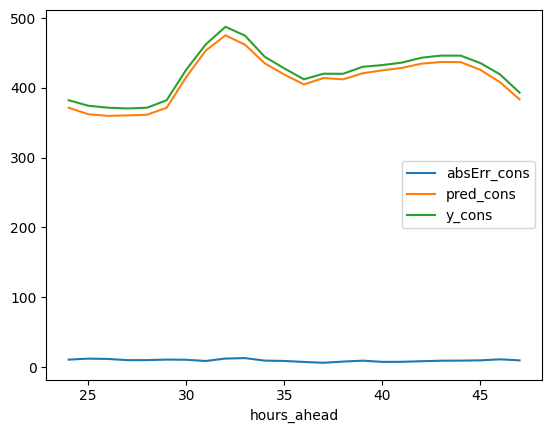

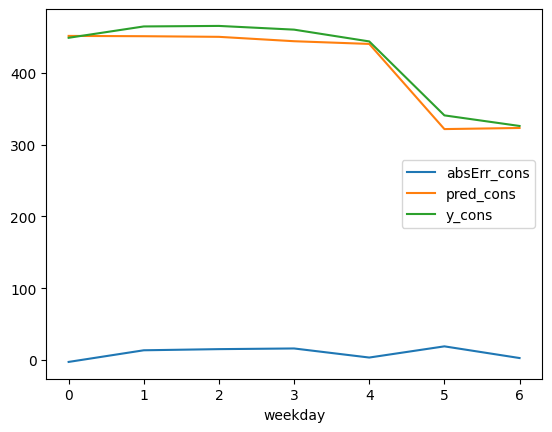

In [126]:
trainDf.groupby('hours_ahead')[['absErr_cons','pred_cons','y_cons']].mean().plot()
trainDf.groupby('weekday')[['absErr_cons','pred_cons','y_cons']].mean().plot()

<Axes: xlabel='unique_time'>

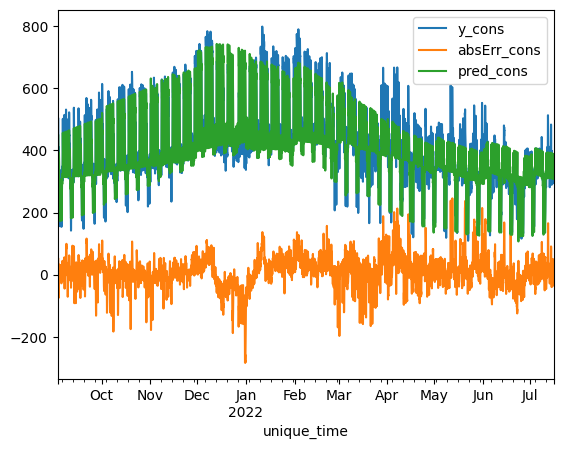

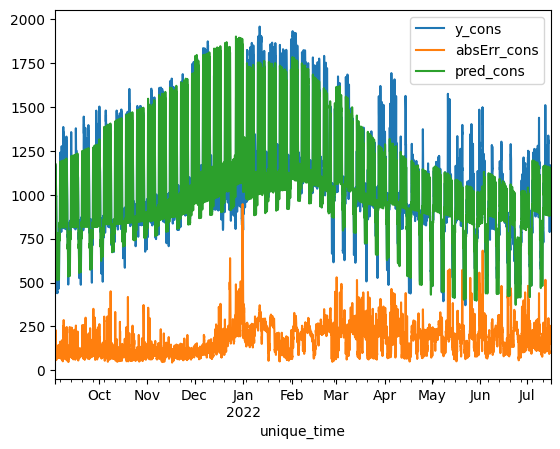

In [127]:
trainDf.groupby('unique_time')[['y_cons','absErr_cons','pred_cons']].mean().plot()
trainDf.groupby('unique_time')[['y_cons','absErr_cons','pred_cons']].std().plot()

In [ ]:
# check correlations to y_cons
for f in ['county', 'is_business',
       'product_type', 
       'business_prodType'
]:
       print('mean', trainDf.groupby(f)[['y_cons']].mean(),'std', trainDf.groupby(f)[['y_cons']].std())
       #print()

for f in ['eic_count', 'installed_capacity','ind_customer_id', 'prediction_unit_id', 
       'lowest_price_per_mwh','highest_price_per_mwh', 
       'yearday', 'weekday', 'month', 'monthday',
]:
       trainDf.groupby(f)[['y_cons']].mean().plot()

### test

<Axes: xlabel='weekday'>

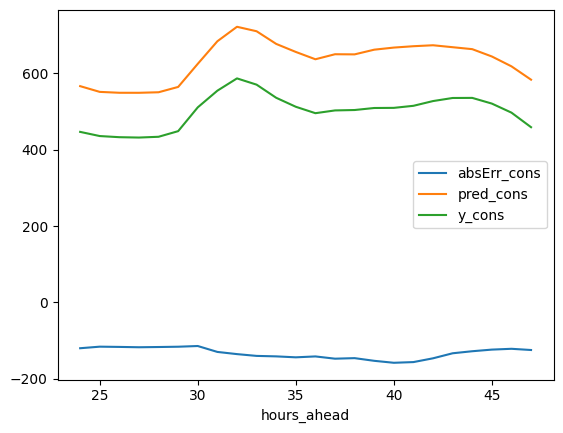

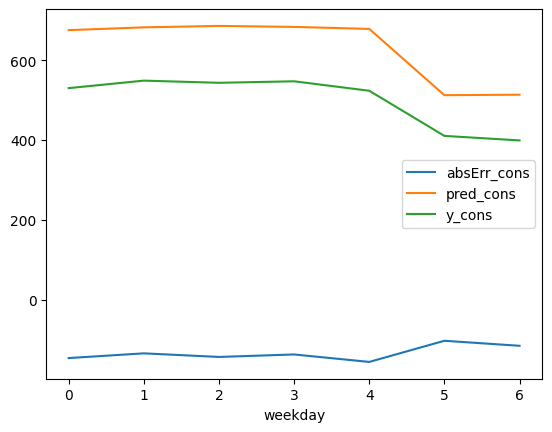

In [128]:
testDf.groupby('hours_ahead')[['absErr_cons','pred_cons','y_cons']].mean().plot()
testDf.groupby('weekday')[['absErr_cons','pred_cons','y_cons']].mean().plot()

<Axes: xlabel='unique_time'>

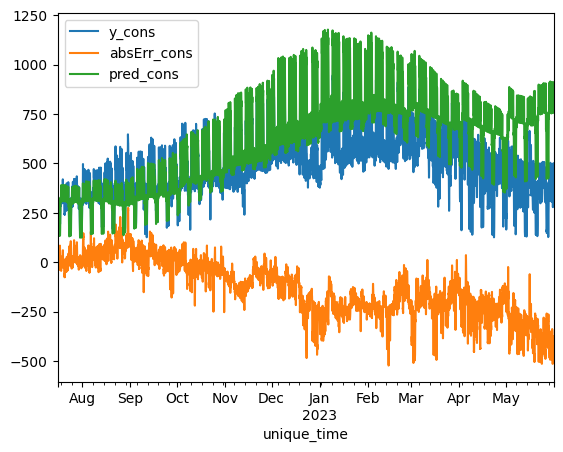

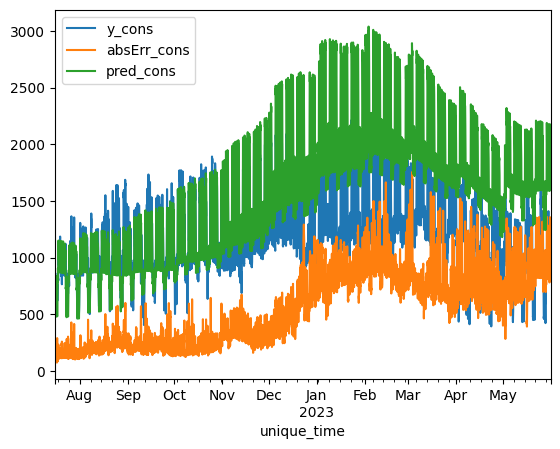

In [129]:
# notice that feb-may in 2023 are way different predictions
testDf.groupby('unique_time')[['y_cons','absErr_cons','pred_cons']].mean().plot()
testDf.groupby('unique_time')[['y_cons','absErr_cons','pred_cons']].std().plot()

In [87]:
testDf.loc[(testDf.data_block_id == 351) & (testDf.hours_ahead == 24)]

y_cons  y_prod  isTrain  data_block_id  county  is_business  \
92760    176.416   0.000      0.0          351.0     7.0          1.0   
292752    37.823   0.000      0.0          351.0    13.0          1.0   
389712    67.187   0.000      0.0          351.0     1.0          1.0   
402360    23.568   0.001      0.0          351.0     2.0          1.0   
409032   762.227   0.000      0.0          351.0     4.0          1.0   
...          ...     ...      ...            ...     ...          ...   
585816   682.455   3.925      0.0          351.0     0.0          0.0   
585936    79.952   0.461      0.0          351.0    11.0          0.0   
586416     9.467   0.000      0.0          351.0    11.0          1.0   
586656   619.219   0.000      0.0          351.0     0.0          1.0   
586824  7087.030   0.775      0.0          351.0     0.0          1.0   

        product_type  prediction_unit_id  eic_count  installed_capacity  ...  \
92760            0.0                28.0       14.0             1468.60  ...   
292752           1.0                63.0        8.0              253.00  ...   
389712           3.0                 8.0       14.0              320.50  ...   
402360           1.0                65.0        7.0              130.00  ...   
409032           0.0                17.0        8.0             1710.00  ...   
...              ...                 ...        ...                 ...  ...   
585816           3.0                 2.0      939.0             9678.11  ...   
585936           1.0                43.0      120.0             1218.00  ...   
586416           2.0                47.0        6.0               90.50  ...   
586656           1.0                 4.0       82.0             2300.20  ...   
586824           3.0                 5.0      377.0            15668.49  ...   

        temperatureint  dewpointint  total_precipitationint    sinDay  \
92760        -3.235998    17.853939                0.000000  0.411037   
292752       -5.541238    16.013743                0.000000  0.663395   
389712       -2.827706    19.680087                0.000202  0.361751   
402360       -4.065462    17.946451                0.000000  0.507403   
409032       -3.743452    15.554341                0.000000  0.470641   
...                ...          ...                     ...       ...   
585816       -4.929499    18.206862                0.000000  0.601414   
585936       -4.703610    15.946064                0.000000  0.577531   
586416       -4.703610    15.946064                0.000000  0.577531   
586656       -4.929499    18.206862                0.000000  0.601414   
586824       -4.929499    18.206862                0.000000  0.601414   

          cosDay  temperatureint  windspeed_10mint  unique_time  pred_cons  \
92760  -0.911619       26.782823          4.317565   2022-08-18        0.0   
292752 -0.748270       25.955949          3.624871   2022-08-18        0.0   
389712 -0.932275       26.451299          5.444444   2022-08-18        0.0   
402360 -0.861709       25.600828          2.992619   2022-08-18        0.0   
409032 -0.882325       25.140906          3.537059   2022-08-18        0.0   
...          ...             ...               ...          ...        ...   
585816 -0.798937       26.407765          3.810444   2022-08-18        0.0   
585936 -0.816369       25.322020          3.378543   2022-08-18        0.0   
586416 -0.816369       25.322020          3.378543   2022-08-18        0.0   
586656 -0.798937       26.407765          3.810444   2022-08-18        0.0   
586824 -0.798937       26.407765          3.810444   2022-08-18        0.0   

        absErr_cons  
92760       176.416  
292752       37.823  
389712       67.187  
402360       23.568  
409032      762.227  
...             ...  
585816      682.455  
585936       79.952  
586416        9.467  
586656      619.219  
586824     7087.030  

[66 rows x 31 columns]

In [202]:
testDf.loc[testDf.ePrices > 1000].unique_time.value_counts()

unique_time
2022-08-18 17:00:00    66
Name: count, dtype: int64

In [33]:
testDf['normCons'] = testDf['y_cons'] / testDf['windspeed_10mint']
testDf['normConsProd'] = testDf['pred_cons'] / testDf['installed_capacity']
testDf = testDf.sort_values(by='unique_time')
a = testDf.loc[(testDf.month == 8)]

fig = subplots.make_subplots(rows=1, cols=1,shared_xaxes=True)

fig.add_trace(go.Scatter(x = a['unique_time'], y = a['y_cons'],mode ='markers', name='y_cons'),row=1, col=1)
fig.add_trace(go.Scatter(x = a['unique_time'], y = a['pred_cons'],mode ='markers', name='pred_cons'),row=1, col=1)
#fig.add_trace(go.Scatter(x = a['unique_time'], y = a['normCons'],mode ='markers', name='normCons'),row=1, col=1)
#fig.add_trace(go.Scatter(x = a['unique_time'], y = a['normConsProd'],mode ='markers', name='normConsProd'),row=1, col=1)
fig.show()

### check individual day difference
maybe some features corrupt result, seems that predictions are sometimes far off
features that are iffy: eic_count, ind_customer_id, prediction_unit_id, year

In [63]:

f = ['y_cons','pred_cons','absErr_cons','county',
 'is_business',
 'product_type',

 'installed_capacity',
 'business_prodType',
 #'lowest_price_per_mwh',
 #'highest_price_per_mwh',
 #'yearday',
 #'weekday',
 #'month',
 #'monthday'
 ]
a = testDf.loc[(testDf.month == 8) & (testDf.monthday == 3) & (testDf.hours_ahead == 25)][f]

In [64]:
b = testDf.loc[(testDf.month == 3) & (testDf.monthday == 3) & (testDf.hours_ahead == 25)][f]

In [65]:
pd.set_option('Display.max_columns', None)
pd.set_option('Display.max_rows', None)
c = pd.merge(a,b,on=['county','is_business','product_type','business_prodType'], suffixes=('_a','_b'),how='outer')
sorted_columns = sorted(c.columns)
c = c[sorted_columns]
c
#features that are iffy: eic_count, ind_customer_id, prediction_unit_id, year

absErr_cons_a  absErr_cons_b  business_prodType  county  \
0      -13.840123     -38.510652                0.0     8.0   
1      -27.121842      -9.652590                2.0     5.0   
2       -0.293125     -43.884515                3.0    10.0   
3     -128.744808      -8.872682                5.0    15.0   
4       86.213699   -1344.828922                6.0     6.0   
5      -22.525737     -39.909203                3.0     1.0   
6      124.794417    -144.828084                5.0     4.0   
7      -11.846056      11.396583                3.0     3.0   
8     -119.546740     -51.086896                2.0     4.0   
9       -3.005069      12.418130                0.0    14.0   
10     249.733930     101.641918                6.0     4.0   
11      -3.759486     -25.366163                6.0    13.0   
12     193.176746     -87.774880                5.0    11.0   
13      -8.671336     -67.997081                3.0     5.0   
14     -48.711004     -10.240364                2.0     9.0   
15      -5.531511     -12.220152                0.0     5.0   
16      -8.323553       2.634216                3.0     8.0   
17     -52.925277       2.624413                2.0    10.0   
18      -3.900601      -2.988061                0.0     1.0   
19       1.512520      47.228497                3.0    13.0   
20      43.139367     -32.970311                2.0    11.0   
21       1.166654       0.443739                0.0    11.0   
22      -6.544240      21.429439                3.0    15.0   
23    -118.564393     454.085158                6.0     5.0   
24    -163.713319     -11.303214                5.0     7.0   
25     128.132215     122.069161                6.0    14.0   
26       0.851273      20.631869                2.0    13.0   
27       9.806168   -2799.837209                6.0     2.0   
28       0.101020      -4.574324                2.0     3.0   
29     251.947185     157.185462                2.0     7.0   
30     -16.678767     -16.623931                0.0     3.0   
31     -10.698353     -17.703100                2.0     2.0   
32     -12.830523     -21.908779                0.0     4.0   
33     -82.363686    -169.207443                2.0     0.0   
34      78.991103    -309.184585                6.0    10.0   
35    -132.834350     394.259091                3.0     0.0   
36     -18.612393     -28.314606                3.0     7.0   
37     -10.780137      -2.001995                4.0     0.0   
38     -28.505815     -20.557995                2.0    14.0   
39    -690.525518    3098.104918                6.0    11.0   
40     120.584247     144.900911                6.0     3.0   
41     -23.884759      -6.107841                3.0     2.0   
42      96.139605     -41.646404                6.0     7.0   
43     -35.400140    -143.742567                6.0     9.0   
44      -8.179060     -66.816495                3.0     4.0   
45      -2.349474      -2.032022                4.0    11.0   
46    -188.470055     -90.479641                0.0     0.0   
47     -29.843798     -24.686566                0.0    10.0   
48      -2.595541       8.466472                0.0    13.0   
49       3.315961            NaN                1.0    11.0   
50     -10.080756     -68.334949                0.0     7.0   
51     -79.189685    -806.243989                6.0    12.0   
52    -103.145814     -30.237393                2.0    15.0   
53     -14.090003      41.142301                3.0    14.0   
54    -145.739070      26.316945                3.0    11.0   
55       2.607272       8.701648                3.0     9.0   
56      -6.460261     -38.167252                6.0     1.0   
57     152.475183     -56.886617                6.0    15.0   
58       5.817683     -28.527905                1.0     0.0   
59      60.358023     152.987503                6.0     8.0   
60      -4.096096      47.891124                0.0    15.0   
61     824.938045      18.770011                5.0     5.0   
62     -38.459865      33.365678   

In [47]:
pd.set_option('Display.max_columns', 10)
pd.set_option('Display.max_rows', 10)